# Import and initialize

## Importing modules

In [1]:
%matplotlib notebook

from IPython.display import clear_output

import sys
sys.path.append(r"D:\OneDrive\BF3\Code");
sys.path.append(r"D:\OneDrive\BF3\Code\labtools-master")

import os
import time
import datetime
import numpy as np
import matplotlib as mpl
import time
# import utils

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

# from labtools import mplplots; reload(mplplots)
# from labtools.mplplots.init_nb_plotting import *
# from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location

#qc.config.subscription.default_subscribers  = ["Plottr"] # use plottr as the live plotting tool

from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.qctools import instruments as instools

#from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

# from MDAC import MDAC 
# from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A

#from qcodes.instrument_drivers.stanford_research.SR860 import SR860
#from qcodes.instrument_drivers.QuTech.IVVI import IVVI
#from qcodes.instrument_drivers.yokogawa.GS200 import GS200

from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment
#qc.config.subscription.default_subscribers.pop()
qc.config.subscription.default_subscribers

[]

## Database configuration

In [2]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [6]:
#qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m-%d.db')
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_2019-03-26.db')
#r'D:\OneDrive\BF3\Data\experiments_2019-03-21.db'
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

In [11]:
ts = time.localtime()
pth = 'Y:\\'+'%02d-%02d-%02d'%(ts.tm_year-2000, ts.tm_mon, ts.tm_mday) + '\\CH9 T 19-03-26.log'
s = np.loadtxt(pth, usecols = (2), delimiter = ',')
print(s)

[ 3.4167   3.4201   3.4201  ...,  3.41498  3.40293  3.40293]


## Initialize instruments

In [6]:
station = Station()

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0301::MY57505052::INSTR", force_new_instance=True)
#key2 = create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR", force_new_instance=True)

from qcodes.instrument_drivers.stanford_research.SR865 import SR865
lockin1 = create_inst(SR865, "lockin1", "GPIB0::4::INSTR", force_new_instance=True)
lockin1.amplitude.vals._min_value = 0

lockin2 = create_inst(SR865, "lockin2", "GPIB0::5::INSTR", force_new_instance=True)
lockin2.amplitude.vals._min_value = 0

station = qc.Station(key1, lockin1, lockin2)

Connected to: Keysight Technologies 34465A (serial:MY57505052, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.92s
Connected to: Stanford_Research_Systems SR860 (serial:003225, firmware:V1.47) in 0.21s
Connected to: Stanford_Research_Systems SR860 (serial:003214, firmware:V1.47) in 0.06s


In [14]:
lockin3 = create_inst(SR865, "lockin3", "GPIB0::6::INSTR", force_new_instance=True)
lockin3.amplitude.vals._min_value = 0

VisaIOError: VI_ERROR_NLISTENERS (-1073807265): No listeners condition is detected (both NRFD and NDAC are deasserted).

In [7]:
print('lockin1 excitation amplitude =', lockin1.amplitude(), 'V')
print('lockin1 DC bias =', lockin1.sine_outdc(), 'V')
print('lockin1 frequency =', lockin1.frequency(), 'Hz')
print('lockin1 phase =', lockin1.phase(), 'deg')
print('lockin1 X =', lockin1.X(), 'V')
print('lockin1 Y =', lockin1.Y(), 'V')
print('lockin1 R =', lockin1.R(), 'V')
print('lockin1 P =', lockin1.P(), 'deg')

lockin1 excitation amplitude = 0.0 V
lockin1 DC bias = 1.7365528038e-06 V
lockin1 frequency = 4.7605 Hz
lockin1 phase = -180.0 deg
lockin1 X = -3.5762786066e-09 V
lockin1 Y = -7.9292803434e-09 V
lockin1 R = 8.5886622259e-09 V
lockin1 P = -75.538131714 deg


In [23]:
lockin2.X()

1.3283194278e-07

### Heater

In [ ]:
#from front panel - interface (6) - select connection to ethernet
from qcodes.instrument_drivers.Lakeshore import Model_372
ls = instools.create_inst(Model_372.Model_372, 'lakeshore_372', 'TCPIP::192.168.0.160::7777::SOCKET')
h = ls.sample_heater

In [ ]:
#Example for heater settings (change it back to USB mode from lakeshore front panel to see it from the PC)

# Specify heater channel
heater_channel = 9;

# Set auto range of heater to enabled = 'current'
heater = ls.channels[heater_channel-1];
heater.auto_range('current')

# PID setup
h.P(1)
h.I(2)
h.D(2)
h.input_channel(heater_channel)
h.setpoint(0) # initialize setpoint to 0 for safety
h.mode('closed_loop')
max_T = [0.014, 0.019, 0.05, 0.15, 0.49, 1.5, 4.5, 10];
h.range_limits(max_T)

### Magnet
Check that the magnet is the "right" one and so the parameters (coil constant and so on...)

In [6]:
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430,AMI430_3D


In [7]:

ami_x = instools.create_inst(AMI430, "AMI430_x", "169.254.178.28", port = 7180, has_current_rating=True)
ami_y = instools.create_inst(AMI430, "AMI430_y", "169.254.175.39", port = 7180, has_current_rating=True)
ami_z = instools.create_inst(AMI430, "AMI430_z", "169.254.137.107", port = 7180, has_current_rating=True)

ramp_limit_multiplier = 0.6
ami_x.current_ramp_limit(0.1)
ami_x.coil_constant(0.01466)
ami_x.current_rating(68.21)

ami_y.current_ramp_limit(0.1)
ami_y.coil_constant(0.01464)
ami_y.current_rating(68.31)

ami_z.current_ramp_limit(0.0775*ramp_limit_multiplier)
ami_z.coil_constant(0.0818)
ami_z.current_rating(73.35)

ami = instools.create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)
ami_3d = AMI430_3D("AMI_3D", ami_x, ami_y, ami_z, 1);

Connected to: AMERICAN MAGNETICS INC. 430 (serial:170029, firmware:2.59) in 1.52s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170028, firmware:2.59) in 0.94s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170027, firmware:2.59) in 1.13s


In [ ]:
print(ami_x.ramp_rate())
print(ami_y.ramp_rate())
print(ami_z.ramp_rate())
ami_x.current_ramp_limit
ami_z.current_ramp_limit()
#30.1802*ramp_limit_multiplier

In [ ]:
print(ami_x.field())
print(ami_y.field())
print(ami_z.field())
print (ami_3d.field_measured())
ami_3d.phi_measured()
ami_3d.z(0.41)



#### Example for magnet non-blocking sweep (ramp_to is the non blocking funcion instead of field function)

In [ ]:
x_setpoint = 0 #E-3; # T
y_setpoint = 0 #E-3; # T
z_setpoint = 0 #E-3; # T

fig = plt.figure('set B');
fig.clear();
fpl = fig.add_subplot(1, 1, 1);

Bx, By, Bz = [], [], [];
eps = 1E-5; # T

ami_x.ramp_rate(0.001); # T/s
ami_y.ramp_rate(0.001); # T/s
ami_z.ramp_rate(0.0015); # T/s

ami_x.ramp_to(x_setpoint);
ami_y.ramp_to(y_setpoint);
ami_z.ramp_to(z_setpoint);

while np.abs(x_setpoint - ami_x.field()) > eps or np.abs(y_setpoint - ami_y.field()) > eps or np.abs(z_setpoint - ami_z.field()) > eps:
    
    Bx.append(ami_x.field());
    By.append(ami_y.field());
    Bz.append(ami_z.field());
    
    fpl.clear();
    fpl.plot(range(0, len(Bx)), np.array(Bx) * 1E3, range(0, len(By)), np.array(By)*1E3, range(0, len(Bz)), np.array(Bz)*1E3);
    fpl.legend(('$B_x$ = {} mT'.format(str(round(Bx[-1]*1E3, 3))), '$B_y$ = {} mT'.format(str(round(By[-1]*1E3, 3))), '$B_z$ = {} mT'.format(str(round(Bz[-1]*1E3, 3)))));
    plt.xlabel('time (s)');
    plt.ylabel('$B_{x,y,z}$ (mT)');
    fig.canvas.draw();
    
    time.sleep(1);

In [ ]:
ami_x.ramp_to(0)
ami_y.ramp_to(0)
ami_z.ramp_to(0)

#### 3D magnet setup

### Playground
![title](240px-3D_Spherical.svg.png)

In [ ]:
# Block/non-block toggle
ami_3d.block_during_ramp(not ami_3d.block_during_ramp())
ami_3d.block_during_ramp()

In [ ]:
# (r, theta, phi)
ami_3d.spherical((0.01, 0, 90))

In [ ]:
ami_3d.spherical_measured()

In [ ]:
ami_3d.cartesian_measured()
ami_3d.block_during_ramp(False)

### Measurement functions
The one for setting lockin voltage should be the only one. If not check the mdac ones in Q216F notebook

In [ ]:
@setter(("lockin_dc", "V"))
def lockin_dc(voltage): 
    voltage *= 100  # Takes into account the attenuator at lockin DC output
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

## Measurements
### Resistance

In [ ]:
def setup():
    key1.NPLC(1)
    lockin_dc(10e-3)
    lockin1.amplitude(5e-4)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #sr1.frequency(117)         # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(3)

def cleanup(): 
    lockin1.amplitude(0)
    lockin_dc(0)
    #ami_x.field(0)
    #ami_z.field(0)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    #V_meas = key2.volt()
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        time.sleep(3)
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    Vac     = adder_atten*lockin1.amplitude()  #*np.sqrt(2)
    L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g = 0

    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

result = do_experiment(
    "Experiment_name/Sample_name",
    nest(
        #sweep(mdac_PG_voltage, np.linspace(1.6, 1.7, 101)),
        sweep(lockin_dc, np.linspace(-1e-3, 1e-3, 201)), # real voltage applied onto device
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=True
)

#### Monitoring R_vs_T (Cooldown)

In [26]:
def setup():
    
    lockin1.sine_outdc(0)
    lockin1.amplitude(2)
    lockin2.sine_outdc(0)
    lockin2.amplitude(2)
    time.sleep(1)
    
def cleanup(): 
    lockin1.sine_outdc(0)
    lockin1.amplitude(0)
    lockin2.sine_outdc(0)
    lockin2.amplitude(0)


    
class RsvsT(Instrument):
    
    def __init__(self, name, **kw):
        super().__init__(name, **kw)        
        self.add_parameter('temperature', get_cmd=self._get_temperature, set_cmd=None, unit='K')
        self.add_parameter('R_UCSB_dev3', get_cmd=self._get_R1, set_cmd=None, unit='Ohms')
        self.add_parameter('R_UCSB_dev4', get_cmd=self._get_R2, set_cmd=None, unit='Ohms')
        self.add_parameter('counter', get_cmd=self._counter, set_cmd=None, unit='')
        self._ind = 0
        self._R_bias = 1e6
    def _counter(self):
        self._ind += 1
        return self._ind
    def _get_temperature(self):
        ts = time.localtime()
        ds = '%02d-%02d-%02d'%(ts.tm_year-2000, ts.tm_mon, ts.tm_mday)
        pth = r'Y:\\'+ ds + '\\CH9 T '+ds+'.log'
        time.sleep(1)
        s = np.loadtxt(pth, usecols = (2), delimiter = ',')
        return s[-1]
    def _get_R1(self):
        I_bias = lockin1.amplitude()/self._R_bias
        V_meas = lockin1.X()
        return V_meas/I_bias
    def _get_R2(self):
        I_bias = lockin2.amplitude()/self._R_bias
        V_meas = lockin2.X()
        return V_meas/I_bias 
        
    
meas_ins = create_inst(RsvsT, 'RsvsT', force_new_instance=True)
setup()
temp = meas_ins.temperature()
r1 = meas_ins.R_UCSB_dev3()
r2 = meas_ins.R_UCSB_dev4()

print('temp =', temp, 'K')  
print('R1 =', r1, 'Ohms') 
print('R2 =', r2, 'Ohms')

type(meas_ins.temperature())



temp = 3.37371 K
R1 = 2.5973645279000004 Ohms
R2 = 2.9941088542000003 Ohms


numpy.float64

In [34]:
meas_ins.temperature()

0.029355800000000001

In [27]:
@setter(("time", "a.u."))
def time_sweep(t): 
    pass

In [36]:
def setup():
    
    lockin1.sine_outdc(0)
    lockin1.amplitude(2)
    lockin2.sine_outdc(0)
    lockin2.amplitude(2)
    time.sleep(1)

def cleanup(): 
    lockin1.sine_outdc(0)
    lockin1.amplitude(0)
    lockin2.sine_outdc(0)
    lockin2.amplitude(0)


@getter(('Temperature', 'K'),
        ('R_1_real', 'Ohm'), ('R_1_imag', 'Ohm'), ('R_2_real', 'Ohm'), ('R_2_imag', 'Ohm'),
        ('Lockin1_R', 'V'), ('Lockin1_P', 'deg'), ('Lockin2_R', 'V'), ('Lockin2_P', 'deg'),
        ('I_exc_1', 'A'), ('I_exc_2', 'A'))
def measure_ac_Ibias(R_bias=1e6):
    time.sleep(5)
    
    T = meas_ins.temperature()

    Iac1     = lockin1.amplitude()/R_bias # excitation current  in A
    L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    Rac1_real = L1X/Iac1    
    Rac1_imag = L1Y/Iac1
    
    Iac2     = lockin2.amplitude()/R_bias # excitation current in A
    L2P     = lockin2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L2R     = lockin2.R()
    L2Y     = lockin2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L2X     = lockin2.X()
    Rac2_real = L2X/Iac2  
    Rac2_imag = L2Y/Iac2

    result  = T, Rac1_real, Rac1_imag, Rac2_real, Rac2_imag, L1R, L1P, L2R, L2P, Iac1, Iac2
    return result

result = do_experiment(
    "R_Al_film_cooldown/UCSB_dev4",
    nest(
        #sweep(mdac_PG_voltage, np.linspace(1.6, 1.7, 101)),
        sweep(time_sweep, np.linspace(0, 1, 5001)),
        measure(measure_ac_Ibias)
    ),
    setup,
    cleanup,
    live_plot=True
)

d:\onedrive\bf3\code\pytopo\pytopo\sweep\do_experiment.py:77: UserWarning: Cannot perform live plots, plottr not installed
  warn("Cannot perform live plots, plottr not installed")


Starting experimental run with id: 5


KeyboardInterrupt: 

In [ ]:
import sys
exp = select_experiment('Al_Characterizations', 'MBE_Al_TUe_Al')

meas = Measurement(exp=exp)
meas.register_parameter(meas_ins.counter)
meas.register_parameter(meas_ins.temperature, setpoints=[meas_ins.counter])
meas.register_parameter(meas_ins.R_MBE, setpoints=[meas_ins.counter])
meas.register_parameter(meas_ins.R_MOVPE, setpoints=[meas_ins.counter])
setup()


with meas.run() as datasaver:

    

    #datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
    #                            min_wait=0, min_count=1)
    kk = 0
    while kk<1000:# meas_ins.temperature() > 0.0.: 
        sys.stdout.write('\b\b\b\b%s'%kk)
        datasaver.add_result((meas_ins.counter, meas_ins.counter()),
                            (meas_ins.temperature, meas_ins.temperature()),
                            (meas_ins.R_MBE, meas_ins.R_MBE()),
                            (meas_ins.R_MOVPE, meas_ins.R_MOVPE()))
        kk+=1
cleanup()

In [ ]:
setup()


#### Plotting traces


In [4]:
dat_cooldown = load_by_id(3)

ValueError: Run with run_id 3 does not exist in the database

<IPython.core.display.Javascript object>


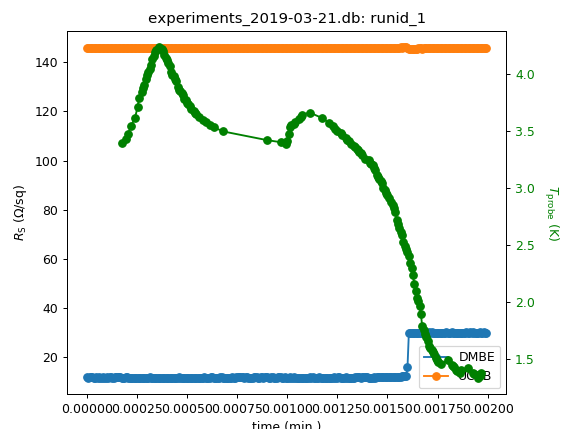

Text(0.5,23.5222,'time (min.)')

In [7]:
dbpth = 'experiments_2019-03-26.db'
dat= load_by_id(3)
pars = dat.get_parameters()
c = pars[0]
T = pars[1]
RMBE = pars[2]
RMOVPE = pars[3]
ind = 300
cs = np.array(dat.get_values(c.name))[:ind,0]*2/60
Ts = np.array(dat.get_values(T.name))[:ind,0]
RMBE = np.array(dat.get_values(RMBE.name))[:ind,0]*np.pi/np.log(2)
RMOVPE = np.array(dat.get_values(RMOVPE.name))[:ind,0]*np.pi/np.log(2)
fig, ax1 = plt.subplots()
ax1.set_title('experiments_2019-03-21.db: runid_1')

ax1.plot(cs, RMBE,'-o',label = 'DMBE')
ax1.plot(cs, RMOVPE,'-o',label = 'UCSB')
plt.ylabel(r'$R_\mathrm{S}$ ($\Omega/$sq)')
ax2 = ax1.twinx()
sel = np.abs(np.diff(Ts))>0.01
ax2.plot(cs[:-1][sel], Ts[:-1][sel], 'go-')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel(r'$T_\mathrm{probe}$ (K)', color = 'g', rotation = -90,labelpad=20)#, pad = 30 )
#ax2.plot(np.diff(Ts))
ax1.legend()
plt.tight_layout()
ax1.set_xlabel('time (min.)')

In [ ]:
plottr

In [ ]:
from plottr import client

In [ ]:
meas.register_custom_parameter?


In [ ]:
np.sqrt(1.268**2+0.037**2)

In [ ]:
theta = np.arctan(0.037/1.268)*180/np.pi

## Field measurements

In [ ]:
ami_x.block_during_ramp(False)

In [ ]:
#ami_3d.x(0.517, block=False)
#ami_x.block(False)
ami_x.set_field(0.517, block = False)
ami_3d.x_measured()

In [38]:
import sys
exp = select_experiment('Al_Characterizations', 'MBE_Al_TUe_Al_Bc')

meas = Measurement(exp=exp)
meas.register_parameter(meas_ins.temperature)
meas.register_parameter(ami_3d.x_measured)
meas.register_parameter(ami_3d.y_measured)
meas.register_parameter(ami_3d.z_measured)
meas.register_parameter(ami_3d.rho_measured)
meas.register_parameter(ami_3d.phi_measured)
meas.register_parameter(ami_3d.theta_measured)


meas.register_parameter(meas_ins.R_MBE, setpoints=[meas_ins.temperature, 
                                                   ami_3d.x_measured, 
                                                   ami_3d.y_measured,
                                                   ami_3d.z_measured,
                                                   ami_3d.rho_measured,
                                                   ami_3d.phi_measured,
                                                   ami_3d.theta_measured
                                                   ])
meas.register_parameter(meas_ins.R_MOVPE, setpoints=[meas_ins.temperature, 
                                                   ami_3d.x_measured, 
                                                   ami_3d.y_measured,
                                                   ami_3d.z_measured,
                                                   ami_3d.rho_measured,
                                                   ami_3d.phi_measured,
                                                   ami_3d.theta_measured
                                                   ])
setup()
def _Bx(Bz):
    return 0.037/1.268*Bz

Bzs = np.linspace(4,4.4,41)
Bxs = _Bx(Bzs)
kk=0

with meas.run() as datasaver:

    
    for Bx, Bz in zip(Bxs, Bzs):
        
        ami_x.set_field(Bx,block=False)
        ami_z.set_field(Bz,block=False)
        time.sleep(np.abs(np.diff(Bzs)[0])/(0.082*0.03)+2)
        #datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
        #                            min_wait=0, min_count=1)



        sys.stdout.write('\b\b\b\b\b%s'%kk)

        datasaver.add_result((meas_ins.temperature, meas_ins.temperature()),
                            (ami_3d.x_measured, ami_3d.x_measured()),
                             (ami_3d.y_measured, ami_3d.y_measured()),
                             (ami_3d.z_measured, ami_3d.z_measured()),
                             (ami_3d.rho_measured, ami_3d.rho_measured()),
                             (ami_3d.phi_measured, ami_3d.phi_measured()),
                             (ami_3d.theta_measured, ami_3d.theta_measured()),                            
                            (meas_ins.R_MBE, meas_ins.R_MBE()),
                            (meas_ins.R_MOVPE, meas_ins.R_MOVPE()))
        kk+=1
cleanup()

Starting experimental run with id: 21
11111111112222222222333333333340

In [ ]:
Bxs = np.linspace(0,0.04,41)
Bzs = np.linspace(0,1.3, 131)

In [ ]:
0.015*.1

In [9]:
Bxs = np.linspace(0.02,0.060,41)

kk=0
ami_3d.x(Bxs[0])

In [ ]:
dbpth = 'experiments_2019-03-21.db'
dat= load_by_id(10)
pars = dat.get_parameters()
Ts=pars[0]
Bxs = pars[1]
R_MBEs = pars[7]
R_MOVPEs = pars[8]

np.array(dat.get_values(Ts.name))

plt.plot(np.array(dat.get_values(Bxs.name)), np.array(dat.get_values(R_MBEs.name)), 'o-')
plt.plot(np.array(dat.get_values(Bxs.name)), np.array(dat.get_values(R_MOVPEs.name)), 'o-')

In [15]:
def _Bx(Bz):
    return 0.037/1.268*Bz

Bzs = np.linspace(0.8,2,41)
Bxs = _Bx(Bzs)

In [17]:
ami_3d.x(0.02334385)

In [20]:
ami_3d.x_measured()

0.0233402

In [30]:
Bzs = np.linspace(0.8,2,121)#np.linspace(0.8,2,121)
121*(np.abs(np.diff(Bzs)[0])/(0.082*0.03)+2)


733.86991869918745

14*121

In [27]:
0.03/0.00246

4.065040650406504

In [28]:
np.diff(Bzs)[0]

0.030000000000000027

In [31]:
Bzs = np.linspace(0.8,2,121)
Bxs = _Bx(Bzs)
kk=0
for Bx, Bz in zip(Bxs, Bzs):
    print(Bx, Bz)

0.0233438485804 0.8
0.0236356466877 0.81
0.023927444795 0.82
0.0242192429022 0.83
0.0245110410095 0.84
0.0248028391167 0.85
0.025094637224 0.86
0.0253864353312 0.87
0.0256782334385 0.88
0.0259700315457 0.89
0.026261829653 0.9
0.0265536277603 0.91
0.0268454258675 0.92
0.0271372239748 0.93
0.027429022082 0.94
0.0277208201893 0.95
0.0280126182965 0.96
0.0283044164038 0.97
0.028596214511 0.98
0.0288880126183 0.99
0.0291798107256 1.0
0.0294716088328 1.01
0.0297634069401 1.02
0.0300552050473 1.03
0.0303470031546 1.04
0.0306388012618 1.05
0.0309305993691 1.06
0.0312223974763 1.07
0.0315141955836 1.08
0.0318059936909 1.09
0.0320977917981 1.1
0.0323895899054 1.11
0.0326813880126 1.12
0.0329731861199 1.13
0.0332649842271 1.14
0.0335567823344 1.15
0.0338485804416 1.16
0.0341403785489 1.17
0.0344321766562 1.18
0.0347239747634 1.19
0.0350157728707 1.2
0.0353075709779 1.21
0.0355993690852 1.22
0.0358911671924 1.23
0.0361829652997 1.24
0.0364747634069 1.25
0.0367665615142 1.26
0.0370583596215 1.27
0.

In [41]:
ami_z.field(5.5)

AMI430Exception: ('_set_field(5.5) failed with state: quench detected', 'setting AMI430_z_field to 5.5')